# Optimization 2 - Project 3: Reinforcement Learning


In [1]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input, Conv3D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
# modify the location where the ROMs are saved on your GoogleDrive
!python -m atari_py.import_roms /content/drive/MyDrive/Roms/

In [4]:
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

In [5]:
# Only needed for policy gradient, approach. 
def discount_rewards(r,delt):
    """Send in an array 'r' of scores and a discount factor 'delt'. This function will return and array of discounted rewards."""
    # take 1D float array of rewards and compute discounted reward
    # gym returns a reward with every single frame.  most of those rewards are 0
    # sometimes they're 1 or -1 if we win or lose a point in that specific frame
    # we want non-0 rewards for every frame. 
    # so take each frame, figure out if we eventually won the corresponding point or not
    # if so make the reward positive, if not negative
    # but more recent actions (relative to the frame where the point is awarded) are more 
    # impactful to the score that frames a long time ago, so discount rewards...
    
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = 1
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r


In [6]:
def move_toward_ball(pixels:np.array) -> int:
    """This function returns the action necessary to move towards the ball."""

    r_pad_y = np.where(pixels[:,71])[0].mean() # Where is our paddle
    ball_p_range = pixels[:,10:70] # What is the range of pixels the ball could be in

    if ball_p_range.sum() < 1:
        action = 0 # If the ball isn't in our range, we don't do anything
    else:
        ball_col = np.where(ball_p_range.sum(axis=0))[0][0]
        ball_y = np.where(ball_p_range[:,ball_col])[0].mean()

        if ball_y > r_pad_y:
            action = 3
        elif ball_y < r_pad_y:
            action = 2
        else:
            action = 0

    return action

Below cells depict a few of the modeling arhitectures we chosen, because it was the one that was the least error prone, but we thought it helpful to keep these here so that we have a record of some of the other options chosen.

In [7]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Flatten()(imp)
    mid = Dense(16,activation='relu',kernel_regularizer = tf.keras.regularizers.l1(0.001))(mid)
    mid = Dense(16,activation='relu',kernel_regularizer = tf.keras.regularizers.l1(0.001))(mid)
    mid = Dense(16,activation='relu',kernel_regularizer = tf.keras.regularizers.l1(0.001))(mid)
    mid = Dense(16,activation='relu',kernel_regularizer = tf.keras.regularizers.l1(0.001))(mid)
    mid = Dense(8,activation='relu',kernel_regularizer = tf.keras.regularizers.l1(0.001))(mid)
    out0 = Dense(3,activation='softmax')(mid)
    model = Model(imp,out0) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.00003),loss='sparse_categorical_crossentropy')
    
    return model

def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Flatten()(imp)
    mid = Dense(16,activation='elu',kernel_regularizer = tf.keras.regularizers.l1(0.0001),kernel_initializer='he_uniform')(mid)
    mid = Dense(4,activation='elu',kernel_regularizer = tf.keras.regularizers.l1(0.0001),kernel_initializer='he_uniform')(mid)
    out0 = Dense(3,activation='softmax',kernel_initializer='he_uniform')(mid)
    model = Model(imp,out0) 
    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.00003),loss='sparse_categorical_crossentropy')
    
    return model

def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(16,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(32,(4,4),strides=2,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(256,activation='relu')(mid)
    mid = Dense(128,activation='relu')(mid)
    out0 = Dense(3,activation='softmax')(mid)
    model = Model(imp,out0) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='sparse_categorical_crossentropy')
    
    return model

# frames_to_net = 4   # how many previous frames will we feed the NN
# possible_actions = [0,2,3] # Do Nothing, Down, Up

# mod = create_model(80,80,frames_to_net)
# # mod = tf.keras.models.load_model('drive/MyDrive/Opti/mod.tf')
# mod.call = tf.function(mod.call,experimental_relax_shapes=True)
# mod.summary()

In [8]:
frames_to_net = 4   # how many previous frames will we feed the NN
possible_actions = [0,2,3] # Do Nothing, Down, Up

### Gameplaying Mechanics
The below function is used to simulate playing one game. It take three arguments: a model to make predictions with, an epsisol_rand, which indicates the likelihood of choosing a random action, and an epsilon_track, which indicates the likelihood of choosing the action that will move the paddle closest to the ball.

We have set up this function so that our model will only make a decision every four frames and that decision is persisted through for the following four frames. This provides a more human like, flow to the gameplay, rather than having a jerky paddle. Additionally, we adjusted how frames, rewards, adn actions are recorded. Instead of saving the feed and reward for every action, we store these values in chunks. The "frame_chunk" that we save is the feed that was used to make the decision for the following four frames. We then save the actions that were chosen over the next four frames and the total rewards that were accumulated.

In [9]:
def play_game(model, epsilon_rand,epsilon_track):
    """Send in a model to make decisions with"""

    env0 = gym.make("Pong-v0")
    pix = env0.reset()
    pix = prepro(pix)
    frames_this_game = 0
    feed = np.zeros((1,80,80,frames_to_net)) # store past four frames. Intially they are blank. 0 index is most recent frame. 3 index is oldest.
    feed[0,:,:,0] = pix.copy() 
    
    frame_chunks = []
    actions = []
    rewards = []
    
    score = 0
    done = False
    fcount = 0
    chunk_reward = 0

    decision_feed = feed.copy()
    action_input = 0

    # Play the game until it is over.
    while not done:
        
        if fcount == 0: # If we are back to fcount of 0 it means we need to make a new decision for next four frames
            if np.random.random() < epsilon_track: # We might track the ball 
                action0 = move_toward_ball(pix)
            elif np.random.random() < epsilon_rand: # Or we may just be quirky and random
                action0 = np.random.choice(possible_actions)
            else:
                vf = model(feed,training=False).numpy()[0] # Get predicted probabilities for best action?
                # action = np.random.choice(3,p=vf) # Randomly choose an action based on those probs
                action0 = np.random.choice(possible_actions,p=vf)
                fcount += 1

            if frames_this_game > 0:
                
                # Store The most recent rewards with their old decisions
                rewards.append(chunk_reward)
                frame_chunks.append(decision_feed)
                actions.append(action_input)

                # Reset the variables for next time
                decision_feed = feed.copy()
                action_input = possible_actions.index(action0)
                chunk_reward = 0 # Reset the rewards for this feed chunk


        elif fcount == 3:
            fcount = 0
        else:
            fcount += 1

        frames_this_game += 1

        # Take our action and get the results!
        pix_new, reward, done, info = env0.step(action0)
        
        score += reward # Total Score
        chunk_reward += reward # Cumulative Score for these four chunks

        pix = prepro(pix_new) # Process the new pixels for the next step
    
        # Shift the feed backward and add in new frame
        feed[0,:,:,1:] = feed[0,:,:,:frames_to_net-1].copy()
        feed[0,:,:,0] = pix.copy()

        if done: # Don't forget to store the last point
            rewards.append(chunk_reward)
            frame_chunks.append(decision_feed)
            actions.append(action_input)

        
    return frame_chunks, actions, rewards, score

# frames, actions, rewards, score =  play_game(mod,0,0)
# score

## Model Training

In [10]:
# Uncomment out the below line if you want to load in an already saved model
mod = tf.keras.models.load_model('drive/MyDrive/Opti/mod.tf')
mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 19, 19, 16)        4112      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          8224      
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 3)                 387   

#### Setting Parameters

In [12]:
ngames = 15_000 # How many games to train for
nbatch = 10 # How many batches per epoch
buffn = 30_000 # How many frame chunks do we want to keep in memory? # Collab can only handle so much.
warmupgames = 15 
delt= .99 # 
epochs = 1
epochs = 2

# What should our probabilities for ball tracking be. We start with 100% chance of ball tracking for the first 5% of games. Then decrease it down to 0 over the next 5% of games.
# Our hope is that this will allow our model to jump start the learning process by examining many successful points.
# eps_tracking = [1]*int(ngames*.05) + list(np.linspace(1,0,int(ngames*.05))) # Possibility for ball tracking for first 30% of ga,es
# How often should we choose a random action:
# eps_rand = list(np.linspace(.05,0,int(ngames*.90)))
eps_rand = []
eps_tracking = []

len_buff = 0
buffer = {'frame_chunks':[],'actions':[],'rewards':[]}
# print(len(eps_tracking))
# print(len(eps_rand))

In [ ]:
rolling_score_total = 0
for game in range(ngames):
    
    start = time.time()

    # Select the appropriate epsilon values for this game.
    if game < len(eps_tracking):
        epsilon_track = eps_tracking[game]
    else:
        epsilon_track = 0
    if game < len(eps_rand):
        epsilon_rand = eps_rand[game]
    else:
        epsilon_rand = 0

    frame_chunks, actions, rewards, score = play_game(mod,epsilon_rand,epsilon_track) # Get results of that one game.
    rewards = discount_rewards(rewards.copy(),delt) # Every single one should have a number. But numbers that are far away from the point will be small.

    # print(f'More Buffing after game = {game}')
    # Add in the new results from the game
    buffer['frame_chunks'] += frame_chunks.copy()
    buffer['actions'] += actions.copy()
    buffer['rewards'] += rewards.copy()
    len_buff += len(actions)

    if len_buff > buffn: 
        # Clean out the older frames if necessary
        excess = len_buff - buffn
        buffer['frame_chunks'] = buffer['frame_chunks'][excess:].copy()
        buffer['actions'] = buffer['actions'][excess:].copy()
        buffer['rewards'] = buffer['rewards'][excess:].copy()
        len_buff = len(buffer['actions'])


    if game >= warmupgames: # After the game is played, we want to update the neural neural network with a random sample from our buffer
        # Set up the inputs and outputs that we will need to feed into the net. 
        frames_to_sample = len(frame_chunks)*2 # We would like a random same of frame chunks, rewards and actions from our buffer.

        rewards = np.zeros(frames_to_sample)
        actions = np.zeros(frames_to_sample)
        current_frames = np.zeros((frames_to_sample,80,80,frames_to_net))

        prob = np.ones(len_buff)
        prob[np.array(buffer['rewards']) > 0] = 10.0 # Weight positive rewards higher than negative rewards.
        prob /= np.sum(prob)
        which_choose = np.random.choice(len_buff,size=frames_to_sample,replace=False,p=prob) # Pick a random sample of frames in the buffer to train on.
    
        for grab in range(frames_to_sample):
            rewards[grab] = buffer['rewards'][which_choose[grab]]
            actions[grab] = buffer['actions'][which_choose[grab]]
            current_frames[grab] = buffer['frame_chunks'][which_choose[grab]]
       
        # Update neural network
        mod.fit(current_frames,actions,epochs=epochs,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)

    stop = time.time()
    rolling_score_total += score
    print(game, score, stop-start,len_buff)
    
    if game % 50 == 0: # Save model every 50 games in awhile
        print(f'Average Score for past 50 games: {rolling_score_total/50}') 
        rolling_score_total = 0
        mod.save('drive/MyDrive/Opti/mod.tf')

# mod.save('drive/MyDrive/Opti/mod.tf')   

## Testing the Trained Model

Now we test the model trained above to see how it performs.

In [15]:
mod_trained = tf.keras.models.load_model('drive/MyDrive/Opti/mod.tf')
scores = []
for game in range(200):
    # Play the game with this model. Both epsilons should be 0 now.
    frame_chunks, actions, rewards, score = play_game(mod_trained,0,0) 
    scores.append(score)

scores = np.array(scores)
scores.mean()

-17.77

''

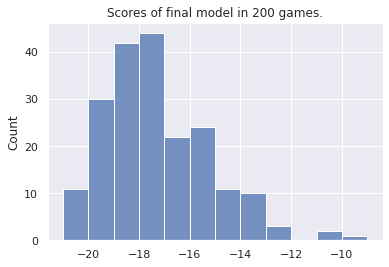

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()


sns.histplot(scores)
plt.title('Scores of final model in 200 games.')
;

In [19]:
scores.max()

-9.0

In [20]:
scores.mean()

-17.77

### Model Training Part 2:
Same as above, but now we only train on 5,000 games.

In [ ]:
mod_2 = create_model(80,80,frames_to_net)
mod_2.call = tf.function(mod_2.call,experimental_relax_shapes=True)

In [ ]:
ngames = 5000
nbatch = 10 # How many batches per epoch
buffn = 30_000 # How many frame chunks do we want to keep in memory? # Collab can only handle so much.
warmupgames = 15 
delt= .99
epochs = 1

eps_tracking = [1]*int(ngames*.05) + list(np.linspace(1,0,int(ngames*.05))) # Possibility for ball tracking for first 30% of ga,es
eps_rand = list(np.linspace(.05,0,int(ngames*.90)))
eps_rand = []

len_buff = 0
buffer = {'frame_chunks':[],'actions':[],'rewards':[]}
print(len(eps_tracking))
print(len(eps_rand))

In [ ]:
rolling_score_total = 0
for game in range(ngames):
    
    start = time.time()

    # Select the appropriate epsilon values for this game.
    if game < len(eps_tracking):
        epsilon_track = eps_tracking[game]
    else:
        epsilon_track = 0
    if game < len(eps_rand):
        epsilon_rand = eps_rand[game]
    else:
        epsilon_rand = 0

    frame_chunks, actions, rewards, score = play_game(mod_2,epsilon_rand,epsilon_track) # Get results of that one game.
    rewards = discount_rewards(rewards.copy(),delt) # Every single one should have a number. But numbers that are far away from the point will be small.

    # print(f'More Buffing after game = {game}')
    # Add in the new results from the game
    buffer['frame_chunks'] += frame_chunks.copy()
    buffer['actions'] += actions.copy()
    buffer['rewards'] += rewards.copy()
    len_buff += len(actions)

    if len_buff > buffn: 
        # Clean out the older frames if necessary
        excess = len_buff - buffn
        buffer['frame_chunks'] = buffer['frame_chunks'][excess:].copy()
        buffer['actions'] = buffer['actions'][excess:].copy()
        buffer['rewards'] = buffer['rewards'][excess:].copy()
        len_buff = len(buffer['actions'])


    if game >= warmupgames: # After the game is played, we want to update the neural neural network with a random sample from our buffer
        # Set up the inputs and outputs that we will need to feed into the net. 
        frames_to_sample = len(frame_chunks) # We would like a random same of frame chunks, rewards and actions from our buffer.

        rewards = np.zeros(frames_to_sample)
        actions = np.zeros(frames_to_sample)
        current_frames = np.zeros((frames_to_sample,80,80,frames_to_net))

        prob = np.ones(len_buff)
        prob[np.array(buffer['rewards']) > 0] = 10.0 # Weight positive rewards higher than negative rewards.
        prob /= np.sum(prob)
        which_choose = np.random.choice(len_buff,size=frames_to_sample,replace=False,p=prob) # Pick a random sample of frames in the buffer to train on.
    
        for grab in range(frames_to_sample):
            rewards[grab] = buffer['rewards'][which_choose[grab]]
            actions[grab] = buffer['actions'][which_choose[grab]]
            current_frames[grab] = buffer['frame_chunks'][which_choose[grab]]
       
        # Update neural network
        mod_2.fit(current_frames,actions,epochs=epochs,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)

    stop = time.time()
    rolling_score_total += score
    print(game, score, stop-start,len_buff)

## Testing the Trained Model 2

Now we test the model trained above to see how it performs.

In [ ]:
scores2 = []
for game in range(200):
    # Play the game with this model. Both epsilons should be 0 now.
    frame_chunks, actions, rewards, scores2 = play_game(mod_2,0,0) 
    scores2.append(scores2)

scores2 = np.array(scores2)
scores2.mean()